Đề tài 9. Dựa vào tập dữ liệu ảnh chữ số viết tay (đã được giáo viên cung cấp trong phần thực hành) đặt trong các thư mục
theo cấu trúc tương tự như trong bài thực hành đã có.
1) Thực hiện việc rút gọn số chiều dữ liệu, sau đó tham khảo để hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc
2D.
2) Thực hiện phân cụm (clustering) dữ liệu gốc bằng 01 thuật toán phân cụm. Hiển thị trực quan và đánh dấu các cụm.
3) Xây dựng chương trình sử dụng mô hình Multinomial Logistic Regression (Softmax) để phân loại các hình ảnh, huấn
luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong tập validation.
4) Xây dựng chương trình sử dụng mô hình CNN để phân loại các hình ảnh. Kiến trúc cụ thể như sau: Mạng gồm ít
nhất 03 tầng tích chập hỗn hợp Convolution + Activation ReLU + Max Pooling, 02 tầng fully connected với số units
phù hợp và tầng quyết định cuối cùng sử dụng softmax. Huấn luyện mô hình bằng tập dữ liệu training sau đó chạy
kiểm tra với dữ liệu trong tập validation.
5) Xây dựng chương trình sử dụng mô hình Multi-Classes Support Vector Machine để phân loại các hình ảnh, huấn
luyện mô hình bằng tập dữ liệu training sau đó chạy kiểm tra với dữ liệu trong tập validation.
6) So sánh độ chính xác (sử dụng accuracy, confusion matrix, recall và precision) của các mô hình trong ý 3) 4) và ý 5).

In [1]:
import os
import numpy as np

# set names to the paths because they're too long
data_path = 'C:/Users/Admin/Desktop/ML/week4/'

# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')

# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

In [2]:
# Xây dựng phương thức đọc dữ liệu từ tệp gzip, giải nén và đưa về định dạng là một dãy ảnh (một dãy ma trận nguyên)

def get_mnist_data(images_path, labels_path, num_images, shuffle=False, _is=True, image_size=28):
    """
    This shuffle param is active when .gz is downloaded at:
    - 'http://yann.lecun.com/exdb/mnist/'
    - This function return random num_images in 60000 or 10000
    """
    # read data
    import gzip # to decompress gz (zip) file
    
    # open file training to read training data
    f_images = gzip.open(images_path,'r')
    
    # skip 16 first bytes because these are not data, only header infor
    f_images.read(16)
    
    # general: read num_images data samples if this parameter is set;
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000)
    
    # read all data to buf_images (28x28xreal_num)
    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # Read labels
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    
    # rearrange to correspond the images and labels
    for i in range(0, real_num):
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)

    # shuffle to get random images data
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        
        images = images[rand_id, :]
        labels = labels[rand_id,]
        
    # change images data to type of vector 28x28 dimentional
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

In [3]:
train_images, train_labels = get_mnist_data(train_images_path, train_labels_path, 5000, shuffle=True)

test_images, test_labels = get_mnist_data(test_images_path, test_labels_path, 10000, _is=False, shuffle=True)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

C:\Users\Admin\AppData\Local\Temp\ipykernel_13616\3917110295.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


(5000, 784) (5000,)
(10000, 784) (10000,)


1) Thực hiện việc rút gọn số chiều dữ liệu, sau đó tham khảo để hiển thị trực quan các phân lớp dữ liệu dạng 3D hoặc
2D.

In [4]:
def get_image(image):
    return image.reshape(28, 28)

def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z
    each column of Z is a set of score
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    """
    Compute softmax values for each sets of scores in V
    each column of V is a set of score
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def _softmax_regression(X, Y, theta, _lambda = 0.5, iterations=20, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss
    
    losses = []
    theta = theta
    d, N = X.shape
    
    for iter in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(theta.T, xi))
            theta += learning_rate * xi.dot((yi - ai).T)
            if (iter * N + i) % batch_size == 0:
                Y_hat = np.dot(theta.T, X)
                losses.append(log_loss(Y, Y_hat))
        Y_hat = np.dot(theta.T, X)
        print(f"epoch {iter} - cost {log_loss(Y, Y_hat) / N}")
        
    return theta, losses


def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location if max probability
    Note that class are indexed by [0, 1, 2, ..., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

8 4


<Figure size 640x480 with 0 Axes>

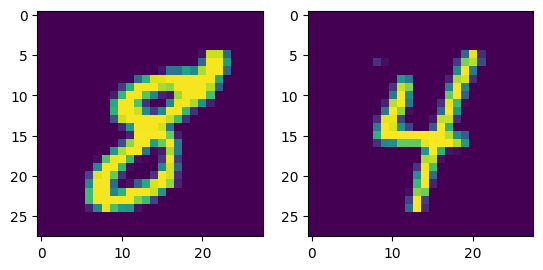

In [5]:
# for display and test digit :D
import random
import matplotlib.pyplot as plt

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])

train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

# use the created array to output your multiple images. In this case I havestacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [6]:
from sklearn.decomposition import PCA as sklearnPCA

X, Y = get_mnist_data(train_images_path, train_labels_path, 10000, shuffle=True)

X_norm = (X - X.min())/(X.max() - X.min())

pca = sklearnPCA(n_components=2)
y_sklearn = pca.fit_transform(X_norm)

pca.explained_variance_ratio_

C:\Users\Admin\AppData\Local\Temp\ipykernel_13616\3917110295.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)


array([0.09517305, 0.07019838], dtype=float32)

In [7]:
import pandas as pd

transformed = pd.DataFrame(y_sklearn)
transformed.head(10)

0         1
0 -0.484808  0.144810
1 -0.982274  2.726319
2  0.984799 -0.200416
3 -3.450052 -2.082602
4 -0.782331  0.223620
5  2.575684  1.837154
6 -1.517693  2.796913
7  2.068156  0.447541
8  0.268141 -1.656726
9 -1.449726  0.104726

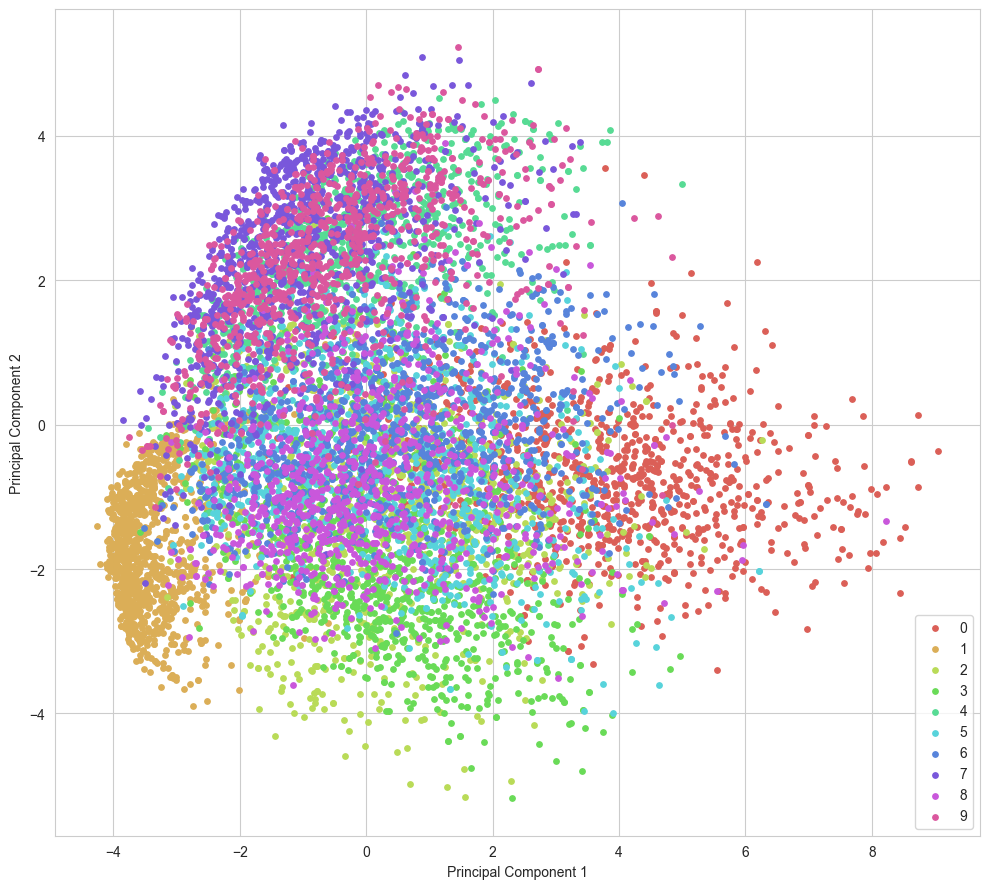

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#husl
plt.figure(figsize=(10, 9))
with sns.axes_style("whitegrid"): 
    for lab, col in zip(range(10), sns.color_palette("hls", 10)):
        plt.scatter(transformed[Y == lab][0], transformed[Y == lab][1], label=lab, c=[col],s=15 )
        # plt.axes(projection ='3d').scatter(transformed[Y == lab][0], transformed[Y == lab][1], transformed[Y == lab][2], label=lab, c=[col],s=15 )
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    # plt.ylabel('Principal Component 3')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


#### 3D

In [9]:
pca_3D = sklearnPCA(n_components=3)
y_sklearn_3D = pca_3D.fit_transform(X_norm)

pca_3D.explained_variance_ratio_

array([0.09517301, 0.07019825, 0.06187205], dtype=float32)

In [10]:
import pandas as pd

transformed_3D = pd.DataFrame(y_sklearn_3D)
transformed_3D.head(10)

0         1         2
0 -0.484788  0.144858 -1.718292
1 -0.982293  2.726370 -0.567963
2  0.984800 -0.200398  1.403157
3 -3.450037 -2.082606  0.319246
4 -0.782333  0.223657 -0.516313
5  2.575690  1.837140  4.984137
6 -1.517690  2.796903  0.158724
7  2.068177  0.447550 -2.162915
8  0.268148 -1.656716  2.403789
9 -1.449704  0.104719  2.277565

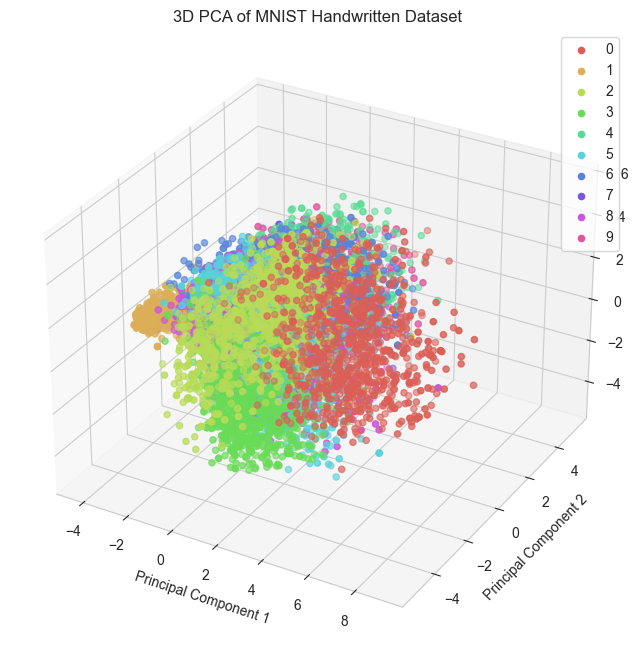

In [11]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(10, 8))
    
    ax = fig.add_subplot(111, projection='3d')
    
    for lab, col in zip(range(10), sns.color_palette("hls", 10)):
        ax.scatter(transformed_3D[Y==lab][0], transformed_3D[Y==lab][1], transformed_3D[Y==lab][2], label=str(lab), c=[col])
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of MNIST Handwritten Dataset')
    
    ax.legend()
    plt.show()

pip install tenacity plotly

In [66]:
type(Y)

numpy.ndarray

In [66]:
import plotly.graph_objs as go
Scene = dict(xaxis = dict(title  = 'Principal Component 1 -->'),yaxis = dict(title  = 'Principal Component 2--->'),zaxis = dict(title  = 'Principal Component 3-->'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = Y
trace = go.Scatter3d(x=y_sklearn_3D[:, 0], y=y_sklearn_3D[:, 1], z=y_sklearn_3D[:, 2], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))

# trace = go.Scatter3d(x=transformed_3D[0], y=transformed_3D[1], z=transformed_3D[2], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))

layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [65]:
# import plotly.graph_objs as go


# labels=Y
# trace = go.Scatter3d(
#     x=transformed_3D[0],
#     y=transformed_3D[1],
#     z=transformed_3D[2],
#     mode='markers',
#     marker=dict(color=labels, size=10, line=dict(color='black', width=10))
# )

# # scene
# scene = dict(
#     xaxis=dict(title='Principal Component 1'),
#     yaxis=dict(title='Principal Component 2'),
#     zaxis=dict(title='Principal Component 3')
# )

# layout = go.Layout(
#     margin=dict(l=0, r=0),
#     scene=scene,
#     height=800,
#     width=800
# )

# data = [trace]
# fig = go.Figure(data=data, layout=layout)
# fig.show()


# traces = []
# for lab, col in zip(range(10), sns.color_palette("hls", 10)):
#     trace = go.Scatter3d(
#         x=transformed_3D[Y==lab][0],
#         y=transformed_3D[Y==lab][1],
#         z=transformed_3D[Y==lab][2],
#         mode='markers',
#         marker=dict(color=col, size=5),
#         name=str(lab)
#     )
#     traces.append(trace)

# # Define layout
# layout = go.Layout(
#     margin=dict(l=0, r=0),
#     scene=dict(
#         xaxis=dict(title='Principal Component 1'),
#         yaxis=dict(title='Principal Component 2'),
#         zaxis=dict(title='Principal Component 3')
#     ),
#     legend=dict(
#         title='Digit',
#         font=dict(size=16),
#         bgcolor='rgba(255, 255, 255, 0.5)',
#         bordercolor='rgba(0, 0, 0, 0.5)',
#         borderwidth=2
#     ),
#     height=800,
#     width=800
# )

# # Create figure
# fig = go.Figure(data=traces, layout=layout)

# # Show figure
# fig.show()

2) Thực hiện phân cụm (clustering) dữ liệu gốc bằng 01 thuật toán phân cụm. Hiển thị trực quan và đánh dấu các cụm.

In [12]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns

In [13]:
def kmeans_display(X, label):
    K = np.amax(label) + 1
    colors = sns.color_palette("hls", n_colors=K) 

    plt.figure(figsize=(10, 8))  
    
    for k in range(K):
        Xk = X[label == k, :]
        plt.scatter(Xk[:, 0], Xk[:, 1],lw=0, s=40, color=colors[k], label=f'Cluster {k}')
        
        # Circle around cluster
        circle = plt.Circle((np.mean(Xk[:, 0]), np.mean(Xk[:, 1])), max(np.std(Xk[:, 0]), np.std(Xk[:, 1])), color=colors[k], fill=False)
        plt.gca().add_artist(circle)

        # Number clusters
        xtext, ytext = np.median(X[label == k, :], axis=0)
        plt.text(xtext, ytext, str(k), fontsize=12, color='black', ha='center', va='center')
    
    plt.axis('equal')
    plt.legend()
    plt.show()

# def kmeans_display(X, label):
#     K = np.amax(label) + 1
#     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple', 'tab:brown'] 
#     markers = ['^', 'o', 's', 'x', 'd', '+', '*', 'p', 'h', '8']  

#     plt.figure(figsize=(10, 9))
#     for k in range(K):
#         Xk = X[label == k, :]
#         plt.plot(Xk[:, 0], Xk[:, 1], color=colors[k], marker=markers[k], markersize=4, alpha=0.8, linestyle='None', label=f'Cluster {k}')
    
#     plt.axis('equal')
#     plt.legend(loc='lower right')
#     plt.show()


In [14]:
def kmeans_init_centers(X, k):
    # randomly pick k rows of X as initial centers
    return X[np.random.choice(X.shape[0], k, replace=False)]

In [15]:
def kmeans_assign_labels(X, centers):
    # calculate pairwise distances btw data and centers
    D = cdist(X, centers)
    # return index of the closest center
    return np.argmin(D, axis = 1)

In [16]:
def kmeans_update_centers(X, labels, K):
    centers = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster
        Xk = X[labels == k, :]
        # take average
        centers[k,:] = np.mean(Xk, axis = 0)
    return centers

In [17]:
def has_converged(centers, new_centers):
    # return True if two sets of centers are the same
    return (set([tuple(a) for a in centers]) == set([tuple(a) for a in new_centers]))

In [18]:
def kmeans(X, K):
    centers = [kmeans_init_centers(X, K)]
    labels = []
    it = 0
    while True:
        labels.append(kmeans_assign_labels(X, centers[-1]))
        new_centers = kmeans_update_centers(X, labels[-1], K)
        if has_converged(centers[-1], new_centers):
            break

        centers.append(new_centers)
        it += 1
    return (centers, labels, it)

In [19]:
K = 10
(centers, labels, it) = kmeans(y_sklearn, K)

print('Centers found by our algorithm:')
print(centers[-1])

Centers found by our algorithm:
[[ 1.54746068  3.06574893]
 [ 2.40772676 -0.19280984]
 [ 1.85189104 -2.32898569]
 [ 0.27355874  0.12447107]
 [-1.69435668  1.58722782]
 [ 5.0603652  -0.92067754]
 [-0.37859312 -1.93881738]
 [-3.43380213 -1.90411115]
 [-2.03631711 -0.43732566]
 [-0.460208    2.86845708]]


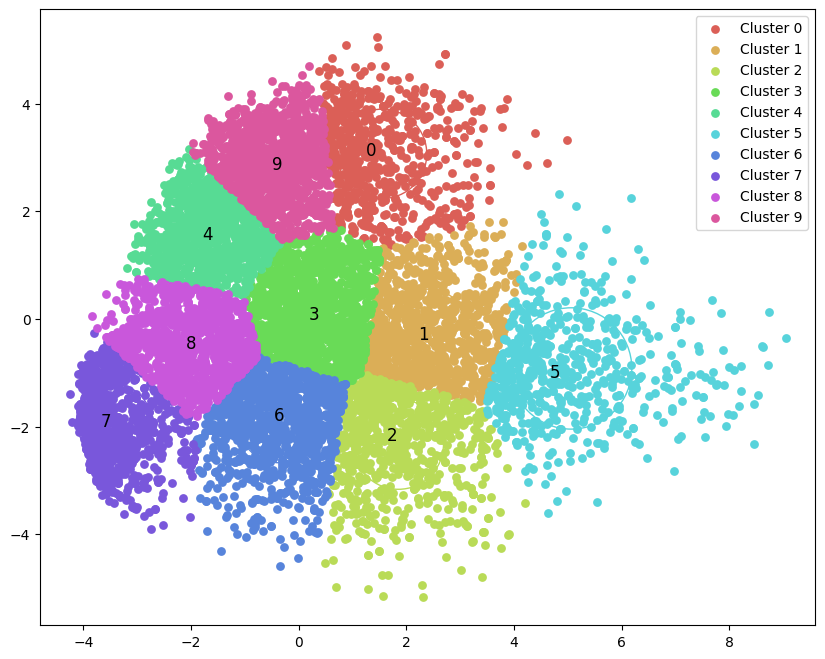

In [21]:
# Hiển thị kết quả phân cụm
kmeans_display(y_sklearn, labels[-1])

##### for searching the ideal cluster number

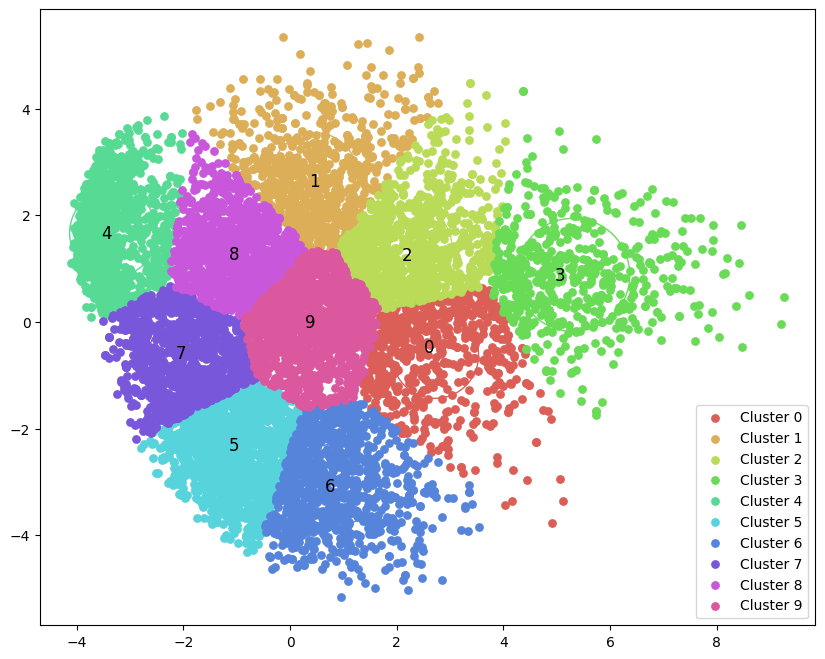

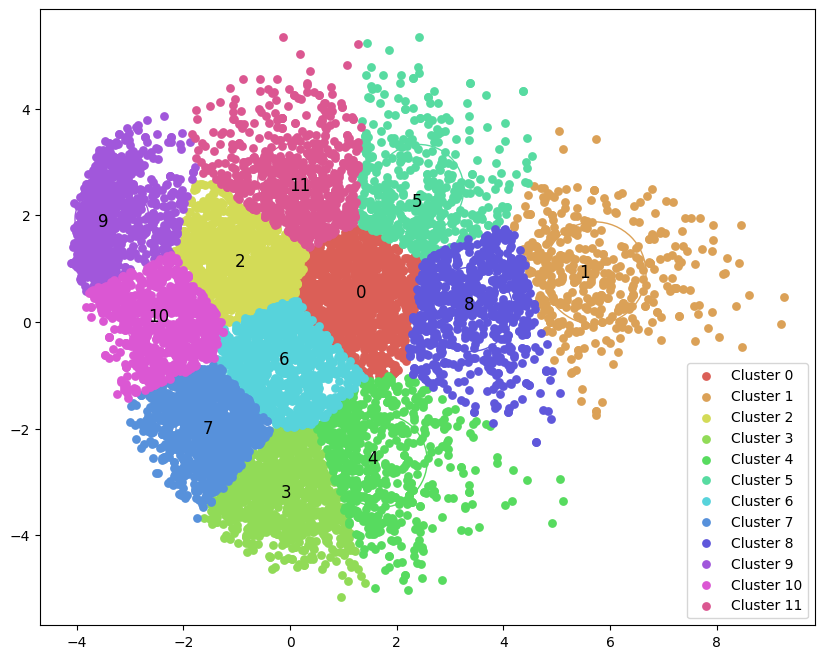

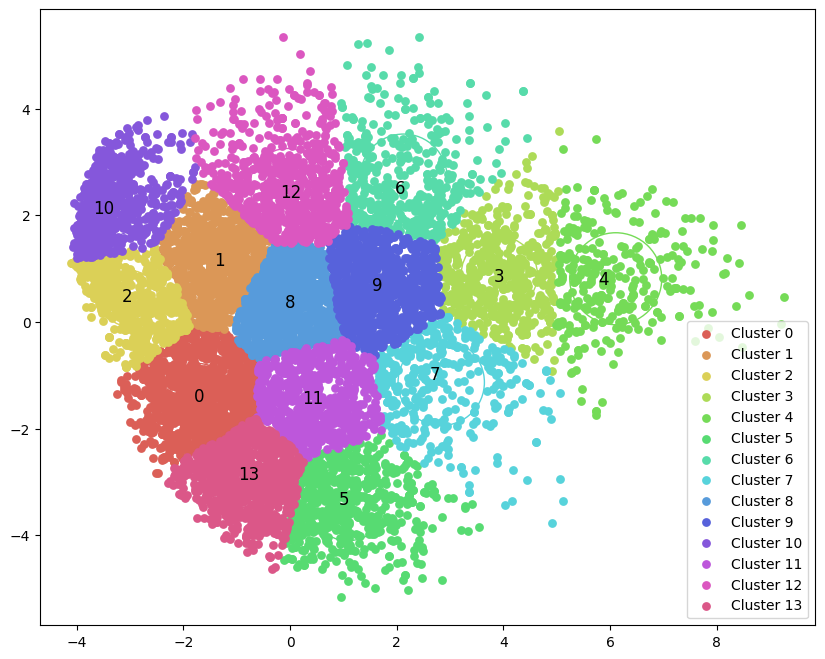

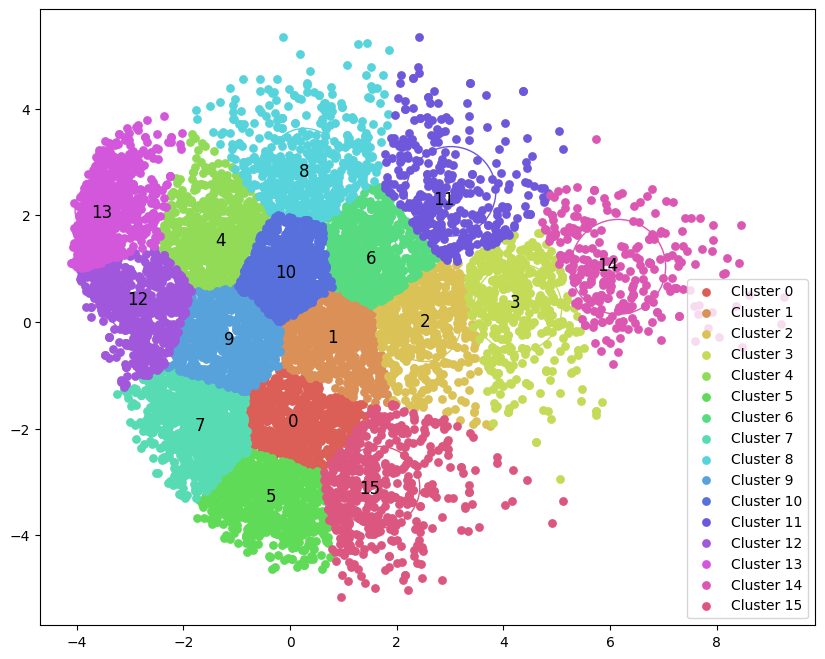

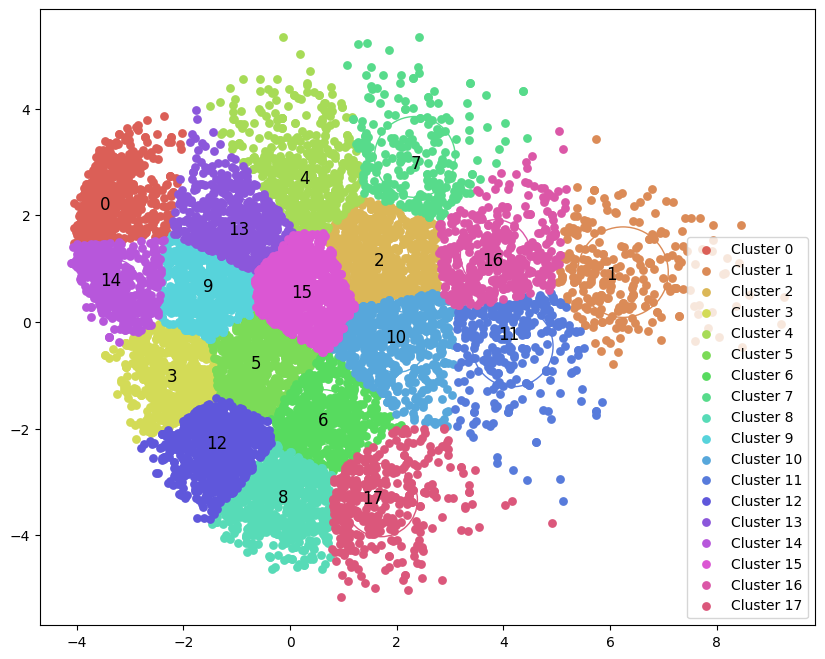

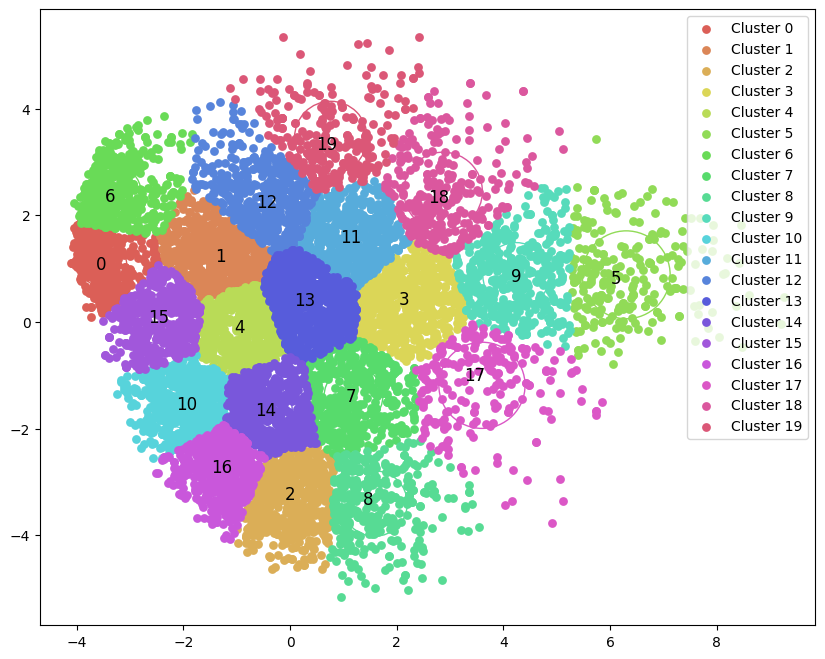

In [101]:
def compute_wcss(X, centers, labels):
    wcss = 0
    for k in range(len(centers)):
        cluster_points = X[labels == k, :]
        wcss += np.sum((cluster_points - centers[k])**2)
    return wcss

K_values = range(10, 21, 2)
wcss_values = []

for k in K_values:
    (centers, labels, it) = kmeans(y_sklearn, k)
    wcss = compute_wcss(y_sklearn, centers[-1], labels[-1])
    wcss_values.append(wcss)
    kmeans_display(y_sklearn, labels[-1])

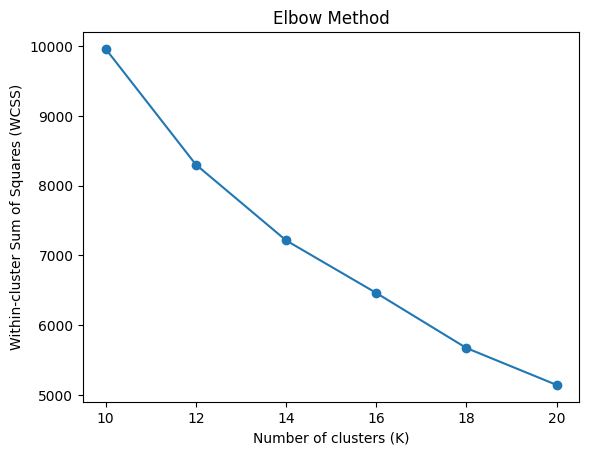

In [103]:
plt.plot(K_values, wcss_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.xticks(K_values)
plt.show()

#### 3D

In [48]:
# hien tai dang lam voi 1 anh do du lieu to 

# optimal_K = K_values[np.argmin(wcss_values)]

optimal_K = 10
(centers, labels, it) = kmeans(y_sklearn_3D, optimal_K)

print('Centers found by our algorithm:')
print(centers[-1])

Centers found by our algorithm:
[[ 2.80322289 -0.37456638  2.87737894]
 [ 5.01609802 -0.96392494 -0.33756068]
 [-0.69142526 -1.19862103 -1.79756546]
 [-1.76023149  1.44095254 -0.12503099]
 [ 0.13112935  2.76474714 -1.55469882]
 [ 1.33255613 -0.78763926  0.07027838]
 [-3.15696287 -1.60677421  0.40422022]
 [ 1.70039356 -1.96632135 -2.72010899]
 [ 0.47142234  2.60721397  1.22759736]
 [-0.56026793 -0.63966495  1.97398484]]


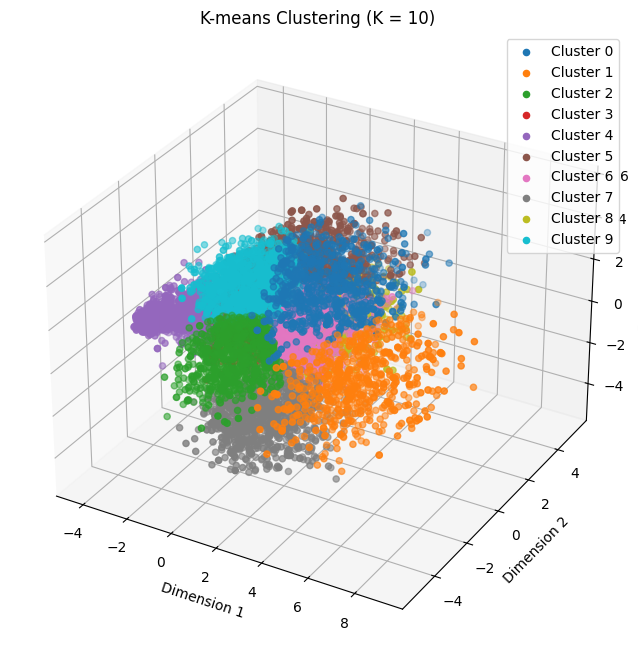

In [56]:
# hien tai dang lam voi 1 anh do du lieu to 

# optimal_K = K_values[np.argmin(wcss_values)]

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(111, projection='3d')

for k in range(optimal_K):
    cluster_points = y_sklearn_3D[labels[-1] == k]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {k}')
    

# for k in range(optimal_K):
#     centroid_x = centers[-1][k, 0]
#     centroid_y = centers[-1][k, 1]
#     centroid_z = centers[-1][k, 2]
#     ax.text(centroid_x, centroid_y, centroid_z, f'Cluster {k}', fontsize=12, color='black', ha='center', va='center')


# ax.scatter(centers[-1][:, 0], centers[-1][:, 1], centers[-1][:, 2], color='red', marker='x', s=200, label='Centroids')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title(f'K-means Clustering (K = {optimal_K})')
ax.legend()
plt.show()

In [61]:
import plotly.graph_objs as go

Scene = dict(xaxis = dict(title  = 'Principal Component 1 -->'),yaxis = dict(title  = 'Principal Component 2--->'),zaxis = dict(title  = 'Principal Component 3-->'))

# colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 
#           'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 
#           'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

labels = Y
for k in range(optimal_K):
    cluster_points = y_sklearn_3D[labels[-1] == k]
    trace = go.Scatter3d(x=cluster_points[:, 0], y=cluster_points[:, 1],z=cluster_points[:, 2],mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
    
# trace = go.Scatter3d(x=cluster_points[:, 0], y=cluster_points[:, 1], z=cluster_points[:, 2], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [63]:
# need to revalue center and poinst
(centers, labels, it) = kmeans(y_sklearn_3D, 10)

# color list
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 'rgb(214, 39, 40)', 
          'rgb(148, 103, 189)', 'rgb(140, 86, 75)', 'rgb(227, 119, 194)', 'rgb(127, 127, 127)', 
          'rgb(188, 189, 34)', 'rgb(23, 190, 207)']


Scene = dict(xaxis=dict(title='Principal Component 1 -->'),
             yaxis=dict(title='Principal Component 2 --->'),
             zaxis=dict(title='Principal Component 3 -->'))


data = []
for k in range(optimal_K):
    cluster_points = y_sklearn_3D[labels[-1] == k]
    trace = go.Scatter3d(x=cluster_points[:, 0],
                         y=cluster_points[:, 1],
                         z=cluster_points[:, 2],
                         mode='markers',
                         marker=dict(color=colors[k], size=5, line=dict(color='black', width=0.5)),
                         name=f'Cluster {k}')
    data.append(trace)

# Add centroids
centroid_trace = go.Scatter3d(x=centers[-1][:, 0],
                              y=centers[-1][:, 1],
                              z=centers[-1][:, 2],
                              mode='markers',
                              marker=dict(color='red', size=10, symbol='x'),
                              name='Centroids')
data.append(centroid_trace)

layout = go.Layout(margin=dict(l=0, r=0),
                   scene=Scene,
                   height=800,
                   width=800,
                   legend=dict(orientation='h', x=0.1, y=1.1),
                   annotations=[dict(text='Legend:', showarrow=False, x=0, y=1.1)])


fig = go.Figure(data=data, layout=layout)
fig.show()